In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore

# 1. CSV 파일에서 데이터 읽기
df = pd.read_csv('./inventory_data.csv', parse_dates=['Date'])


In [5]:
df

,Date,Product,Inbound,Outbound,Restock
0,2025-05-09,Product_1,23,9,0.0
1,2025-05-10,Product_1,15,13,0.0
2,2025-05-11,Product_1,21,17,0.0
3,2025-05-12,Product_1,25,15,0.0
4,2025-05-13,Product_1,15,17,0.0
...,...,...,...,...,...
305,2025-07-05,Product_5,22,14,0.0
306,2025-07-06,Product_5,18,19,0.0
307,2025-07-07,Product_5,22,21,0.0
308,2025-07-08,Product_5,23,17,0.0


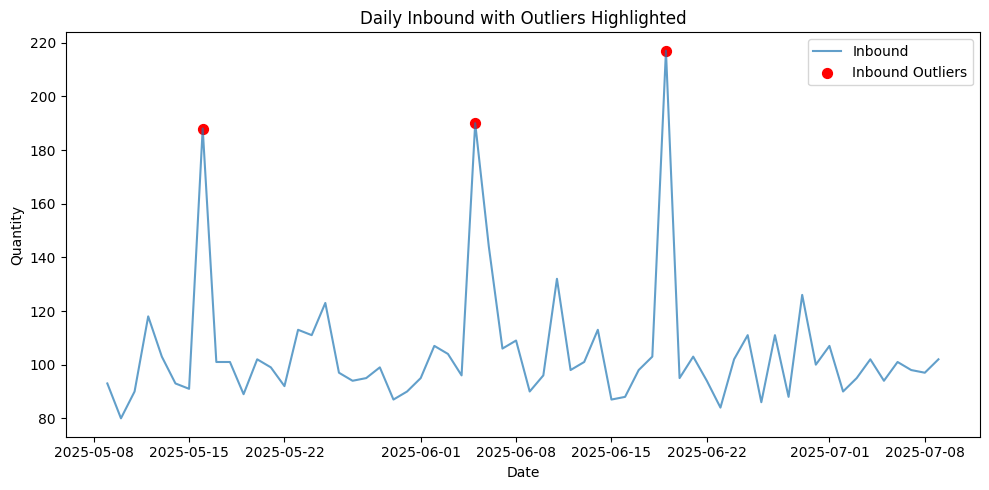

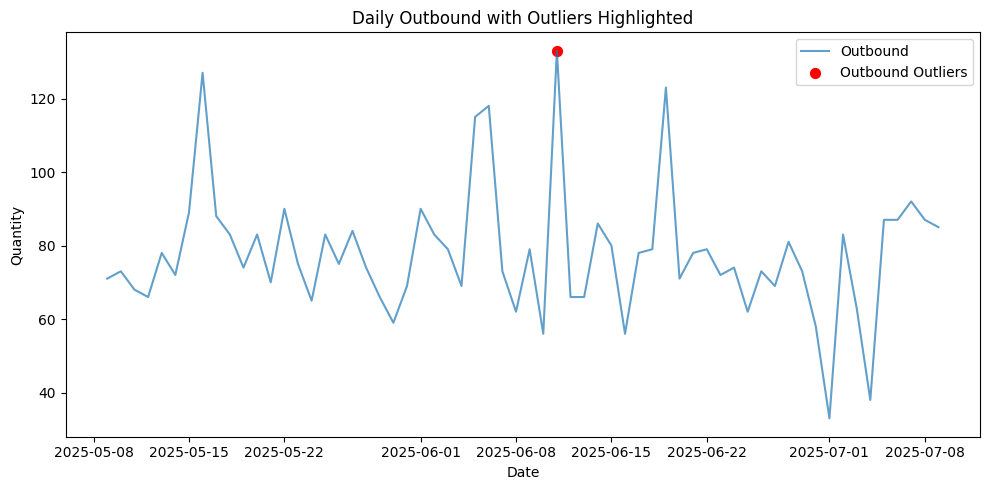

In [4]:



# 2. 일별 Inbound/Outbound 합계 집계
daily = df.groupby('Date')[['Inbound', 'Outbound']].sum()

# 3. Z-Score 계산
daily['inbound_z']  = zscore(daily['Inbound'])
daily['outbound_z'] = zscore(daily['Outbound'])

# 4. 이상치 플래그 (|Z| > 3)
daily['inbound_outlier']  = daily['inbound_z'].abs()  > 3
daily['outbound_outlier'] = daily['outbound_z'].abs() > 3

# 5. Inbound 이상치 시각화
plt.figure(figsize=(10, 5))
plt.plot(daily.index, daily['Inbound'], label='Inbound', alpha=0.7)
plt.scatter(
    daily.index[daily['inbound_outlier']],
    daily['Inbound'][daily['inbound_outlier']],
    color='red', s=50, label='Inbound Outliers'
)
plt.title('Daily Inbound with Outliers Highlighted')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()
plt.tight_layout()
plt.show()

# 6. Outbound 이상치 시각화
plt.figure(figsize=(10, 5))
plt.plot(daily.index, daily['Outbound'], label='Outbound', alpha=0.7)
plt.scatter(
    daily.index[daily['outbound_outlier']],
    daily['Outbound'][daily['outbound_outlier']],
    color='red', s=50, label='Outbound Outliers'
)
plt.title('Daily Outbound with Outliers Highlighted')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()
plt.tight_layout()
plt.show()


<Figure size 1000x500 with 0 Axes>

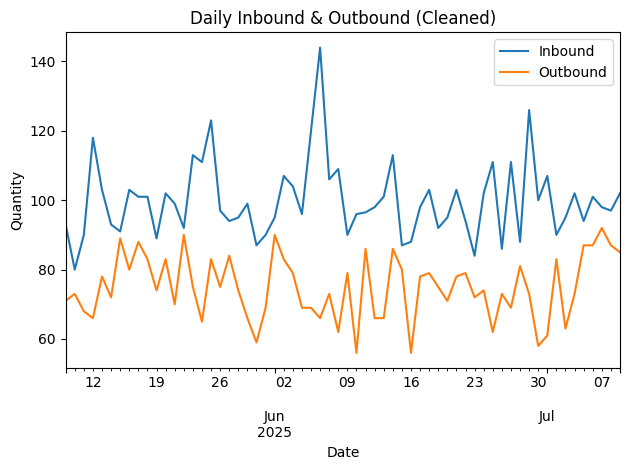

0.006169575180680932
74.66666666666666


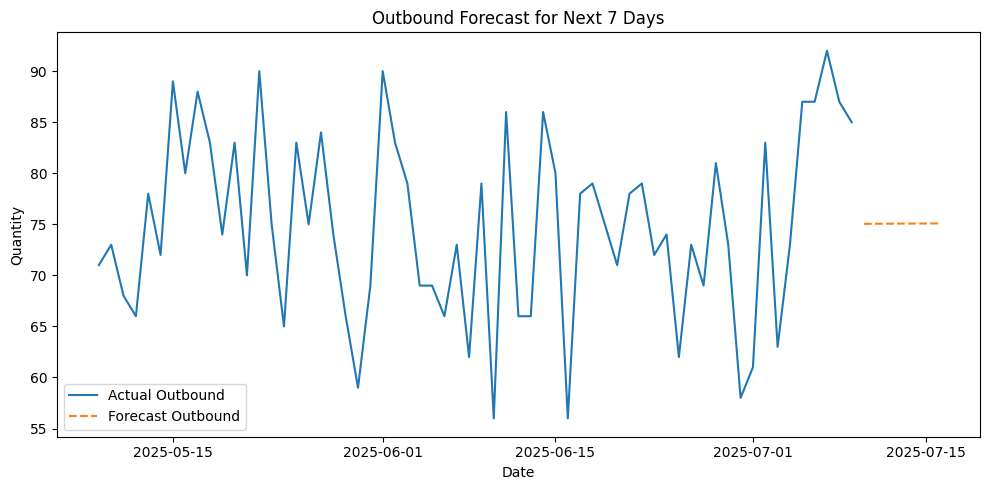

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt

def main():
    # 1. 기존에 생성된 CSV 파일 읽기
    df = pd.read_csv('./inventory_data.csv', parse_dates=['Date'])

    # 2. 이상치 탐지 및 보정 (상품별 Z-Score > 3 → 중앙값, 음수 → 0으로 클리핑)
    df_clean = df.copy()
    for col in ['Inbound', 'Outbound']:
        df_clean[col] = (
            df_clean
            .groupby('Product')[col]
            .transform(lambda x: np.where(
                np.abs(zscore(x.fillna(x.mean()))) > 3,
                x.median(),
                x
            ))
        )
        df_clean[col] = df_clean[col].clip(lower=0)

    # 3. 일별 입/출고 합계 집계
    daily = df_clean.groupby('Date')[['Inbound', 'Outbound']].sum()

    # 4. 일별 입/출고 현황 라인 그래프
    plt.figure(figsize=(10, 5))
    daily.plot()
    plt.title('Daily Inbound & Outbound (Cleaned)')
    plt.xlabel('Date')
    plt.ylabel('Quantity')
    plt.tight_layout()
    plt.show()

    # 5. 출고량 단순 선형 추세 예측 (다음 7일)
    x = np.arange(len(daily))
    y = daily['Outbound'].values
    m, b = np.polyfit(x, y, 1) # m = 기울기, b = 절편, 직선회귀
    print(m)
    print(b)

    future_x = np.arange(len(daily), len(daily) + 7)
    forecast = m * future_x + b
    forecast_dates = pd.date_range(
        start=daily.index[-1] + pd.Timedelta(days=1),
        periods=7,
        freq='D'
    )

    plt.figure(figsize=(10, 5))
    plt.plot(daily.index, y, label='Actual Outbound')
    plt.plot(forecast_dates, forecast, '--', label='Forecast Outbound')
    plt.title('Outbound Forecast for Next 7 Days')
    plt.xlabel('Date')
    plt.ylabel('Quantity')
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
